In [60]:
import nmp_util
from nmp_util import *

In [61]:
r_sym, phi_sym = sympy.symbols('r, phi')

# expression for the variable transformation f
f_expr = sympy.Matrix([
    r_sym*sympy.cos(phi_sym), 
    r_sym*sympy.sin(phi_sym)
])

display(f_expr)
print(sympy.latex(f_expr))
formula, K = nmp_util.error_propagation_formula(f_expr,[r_sym,phi_sym])

display(formula)
print(sympy.latex(formula))

k11, k22 = sympy.symbols('k11, k22')
diagonal_k = sympy.diag([k11,k22], unpack=True)

#doit is necessary to perform matmul
formula = formula.subs({K:diagonal_k}).doit() 

display(formula)
print(sympy.latex(formula))

Matrix([
[r*cos(phi)],
[r*sin(phi)]])

\left[\begin{matrix}r \cos{\left(\phi \right)}\\r \sin{\left(\phi \right)}\end{matrix}\right]


Matrix([
[cos(phi), -r*sin(phi)],
[sin(phi),  r*cos(phi)]])*K*Matrix([
[   cos(phi),   sin(phi)],
[-r*sin(phi), r*cos(phi)]])

\left[\begin{matrix}\cos{\left(\phi \right)} & - r \sin{\left(\phi \right)}\\\sin{\left(\phi \right)} & r \cos{\left(\phi \right)}\end{matrix}\right] K \left[\begin{matrix}\cos{\left(\phi \right)} & \sin{\left(\phi \right)}\\- r \sin{\left(\phi \right)} & r \cos{\left(\phi \right)}\end{matrix}\right]


Matrix([
[            k11*cos(phi)**2 + k22*r**2*sin(phi)**2, k11*sin(phi)*cos(phi) - k22*r**2*sin(phi)*cos(phi)],
[k11*sin(phi)*cos(phi) - k22*r**2*sin(phi)*cos(phi),             k11*sin(phi)**2 + k22*r**2*cos(phi)**2]])

\left[\begin{matrix}k_{11} \cos^{2}{\left(\phi \right)} + k_{22} r^{2} \sin^{2}{\left(\phi \right)} & k_{11} \sin{\left(\phi \right)} \cos{\left(\phi \right)} - k_{22} r^{2} \sin{\left(\phi \right)} \cos{\left(\phi \right)}\\k_{11} \sin{\left(\phi \right)} \cos{\left(\phi \right)} - k_{22} r^{2} \sin{\left(\phi \right)} \cos{\left(\phi \right)} & k_{11} \sin^{2}{\left(\phi \right)} + k_{22} r^{2} \cos^{2}{\left(\phi \right)}\end{matrix}\right]


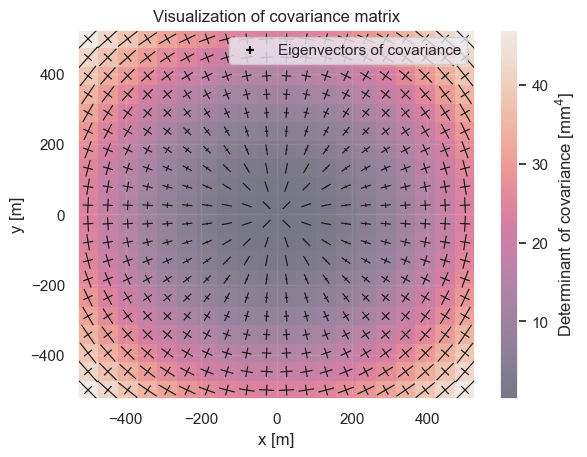

In [62]:
# plot a 1 square kilometer area
_x = np.linspace(-500_000,500_000, 20)
_y = np.linspace(-500_000,500_000, 20)

x, y = np.meshgrid(_x, _y)

# polar coordinates for further calculations
r = np.sqrt(x**2 + y**2)
phi = np.atan2(y, x)

r_cov = 2**2 # mm
phi_cov = np.deg2rad(1/3600)**2 # 1''

# compute covariances via formula from previous cell
covariance_lambda = sympy.lambdify([k11, k22, r_sym, phi_sym], formula)
covariances = covariance_lambda(r_cov, phi_cov,r,phi)

#we need to rotate the axis beacause np.linalg expects a shape (...,m,n)
covariances = np.moveaxis(covariances, [0,1], [2,3])

plt.figure()
plt.title('Visualization of covariance matrix')
nmp_util.matrix_quiver(x/1000, y/1000, covariances, shade_determinant=True, label = 'Eigenvectors of covariance', det_label='Determinant of covariance [mm$^4$]')
plt.legend()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()

In [63]:
campPP_df = nmp_util.read_dat('campPP_mar2024.dat', names = ['angle [°]', 'r [mm]']).astype(float)

xy_vals is an array of 2x1 column vectors (2, 1, 38)


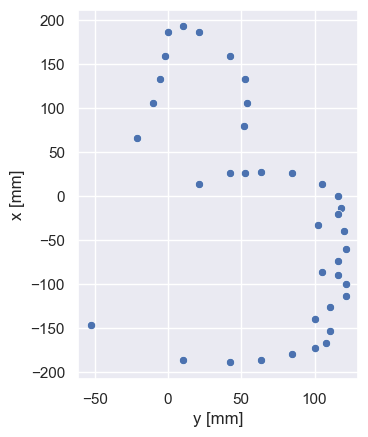

In [72]:
f_lambda = sympy.lambdify([phi_sym, r_sym],f_expr)
xy_vals = f_lambda(np.deg2rad(campPP_df['angle [°]']), campPP_df['r [mm]'])
print(f'xy_vals is an array of 2x1 column vectors {xy_vals.shape}')
campPP_df['x [mm]'] = xy_vals[0,0,:]
campPP_df['y [mm]'] = xy_vals[1,0,:]
plt.axes().set_aspect(0.6)
sns.scatterplot(campPP_df, x = 'y [mm]', y = 'x [mm]')
plt.show()

# Create covariance matrix as $2n \times 2n$ matix

(2, 2, 38)


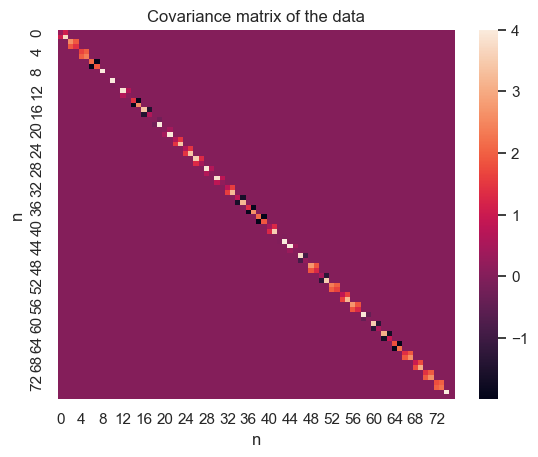

In [65]:
from scipy.linalg import block_diag

covariances  : np.ndarray = covariance_lambda(r_cov, phi_cov, campPP_df['r [mm]'], campPP_df['angle [°]'])

print(covariances.shape)
covariance_matrix = block_diag(*covariances.swapaxes(2,0))

plt.title('Covariance matrix of the data')
sns.heatmap(covariance_matrix)
plt.xlabel('n')
plt.ylabel('n')
plt.show()